# **ETL**

Se importaron las librerías utilizadas en el proyecto.

In [1]:
import numpy as np
import pandas as pd
import json
import ast
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from scipy.stats import norm
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Se importaron las dos bases de datos utilizadas.

In [2]:
#data1 = pd.read_excel('Datasets/Dataset/movies_dataset(1).xlsx')
#data2 = pd.read_excel('Datasets/Dataset/movies_dataset.xlsx')
data1 = pd.read_csv('C:/Users/Bienvenido/OneDrive/Documents/CursoHenry/ProyectoIndividual1/Datasets/Dataset/movies_dataset.csv')
data2 = pd.read_csv('C:/Users/Bienvenido/OneDrive/Documents/CursoHenry/ProyectoIndividual1/Datasets/Dataset/credits.csv')


C:\Users\Bienvenido\AppData\Local\Temp\ipykernel_7136\1019940069.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('C:/Users/Bienvenido/OneDrive/Documents/CursoHenry/ProyectoIndividual1/Datasets/Dataset/movies_dataset.csv')


Se concatenaron las dos tablas anteriores, tomando en cuenta como lista en común el Id de la película. Además se eliminaron duplicados de esta misma columna.

In [3]:
#Cambiar el id de la tabla de credits, de tipo int a str
data2['id'] = data2['id'].astype(str) 
#Concatenar
data = pd.merge(data1, data2, on='id')
#Eliminar duplicados de id
data = data.drop_duplicates(subset='id')

Se desanidaron los datos de las columnas que tenían listas de diccionarios, obteniendo los necesarios para nuestro análisis datos en las columnas: `belongs to collection`, `genres`, `production_companies`, `production_countries`,`spoken_languaje`, `crew` y `cast`

In [4]:
 #Columna belongs_to_collection.
def parse_dict(value):
    if pd.isna(value):
        return np.nan
    else:
        return ast.literal_eval(value)
# Transformar la columna a tipo diccionario utilizando la función auxiliar
data['belongs_to_collection'] = data['belongs_to_collection'].apply(parse_dict)
# Extraer la clave 'name' de cada diccionario, usando  apply()
data['belongs_to_collection'] = data['belongs_to_collection'].apply(lambda x: [x['name']] if isinstance(x, dict) else x)

#Columna genres
data['genres'] = data['genres'].apply(lambda x: [g['name'] for g in ast.literal_eval(x)] if isinstance(x, str) else np.nan)

#Columna production_companies
data['production_companies'] = data['production_companies'].apply(lambda x: [c['name'] for c in ast.literal_eval(x)] if isinstance(x, str) else np.nan)

#Columna production_countries
data['production_countries'] = data['production_countries'].apply(lambda x: [c['name'] for c in ast.literal_eval(x)] if isinstance(x, str) else np.nan)

#Columna spoken_languages
data['spoken_languages'] = data['spoken_languages'].apply(lambda x: [s['name'] for s in ast.literal_eval(x)] if isinstance(x, str) else np.nan)

#Columna crew
data['director'] = data['crew'].apply(lambda x: [d['name'] for d in ast.literal_eval(x) if d['job'] == 'Director'] if isinstance(x, str) else np.nan)

#Columna cast
data['cast'] = data['cast'].apply(lambda x: [c['name'] for c in ast.literal_eval(x)] if isinstance(x, str) else np.nan)

Los valores nulos de los campos `revenue` y ``budget`` fueron rellenados por el número 0.

In [5]:
data['revenue'] = data['revenue'].fillna(0)

Los valores nulos del campo ``release`` date fueron eliminados.

In [6]:
data = data.dropna(subset=['release_date'])

Cambiamos el formato de fecha en la columna ``release_date`` y se anadió una columna llamada ``release_year``, la cual indica el año en el que se estrenó la película.

In [7]:
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

# Cambiar el formato de la columna "release_date" a AAAA-mm-dd
data['release_date'] = data['release_date'].dt.strftime('%Y-%m-%d')

# Extraer el año y crear la nueva columna "release_year"
data['release_year'] = pd.to_datetime(data['release_date']).dt.year

Se creó la columna con el retorno de inversión, llamada ``return`` con los campos ``revenue y budget``, dividiendo estas dos últimas _`revenue / budget`_, cuando no hay datos disponibles para calcularlo, deberá tomar el valor 0. 

In [8]:
#Cambiar a float la variable budget
data['budget'] = pd.to_numeric(data['budget'], errors='coerce')
data['budget'] = data['budget'].astype(float)

#Cambiar a float la variable revenue
data['revenue'] = pd.to_numeric(data['revenue'], errors='coerce')
data['revenue'] = data['revenue'].astype(float)

#Obtener nueva columna return
data['return'] = data['revenue'] / data['budget']
data['return'] = data['return'].fillna(0)

Se eliminaron las columnas que no serán utilizadas, las cuales fueron las siguientes: ``video,imdb_id,adult,original_title,poster_path y homepage``

In [9]:
columnas_eliminadas = ['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage']
data = data.drop(columnas_eliminadas, axis=1)

In [10]:
#columnas =['id','title','original_language','runtime','release_year','belongs_to_collection','revenue','production_countries','production_companies','director','return','budget']
#data = data[columnas]
#data.to_csv('Datasets/Dataset/movies_etl_fa.csv', index = False)

In [11]:
#data.to_csv('Datasets/Dataset/movies_etl.csv', index = False)

# **EDA**

Se va a utilizar la base de datos proveniente del ETL. Para este análisis exhaustivo de datos se observó el comportamiento de las variables numéricas, así como, las variables categóricas.

# Variables numéricas

Primero, se eligieron las columnas que me parecieron que tienen más relación con el **_modelo de Recomendación de películas_** , las cuales fueron: `popularity`, `vote_average`y `vote_count`.

In [12]:
data['popularity'] = data['popularity'].astype(float)
data_num = data[['popularity', 'vote_average', 'vote_count']]

De las variables que quedaron en la tabla anterior, se observaron algunos de sus _`datos estadísticos`_.

In [13]:
data.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,release_year,return
count,4.534500e+04,45345.000000,4.534500e+04,45099.000000,45345.000000,45345.000000,45345.000000,45345.0
mean,4.232673e+06,2.926248,1.123390e+07,94.179893,5.624320,110.137722,1991.882280,inf
std,1.744391e+07,6.011023,6.441058e+07,38.346636,1.915178,491.904428,24.053016,NaN
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1874.000000,0.0
25%,0.000000e+00,0.388826,0.000000e+00,85.000000,5.000000,3.000000,1978.000000,0.0
50%,0.000000e+00,1.130269,0.000000e+00,95.000000,6.000000,10.000000,2001.000000,0.0
75%,0.000000e+00,3.689610,0.000000e+00,107.000000,6.800000,34.000000,2010.000000,0.0
max,3.800000e+08,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000,2020.000000,inf


También, se hizo una _`matriz de correlación`_ para ver la relación que existen entre estas variables.

In [14]:
mapa = data_num.corr()
mapa.style.background_gradient(cmap='coolwarm')

,popularity,vote_average,vote_count
popularity,1.000000,0.153717,0.559955
vote_average,0.153717,1.000000,0.123602
vote_count,0.559955,0.123602,1.000000


Se analizaron los _`outliers`_ de la base de datos para elegir la(s) mejor(es) varibles con ayuda de un _`histograma`_ y un _`diagrama de dispersión`_ para cada una de éstas.

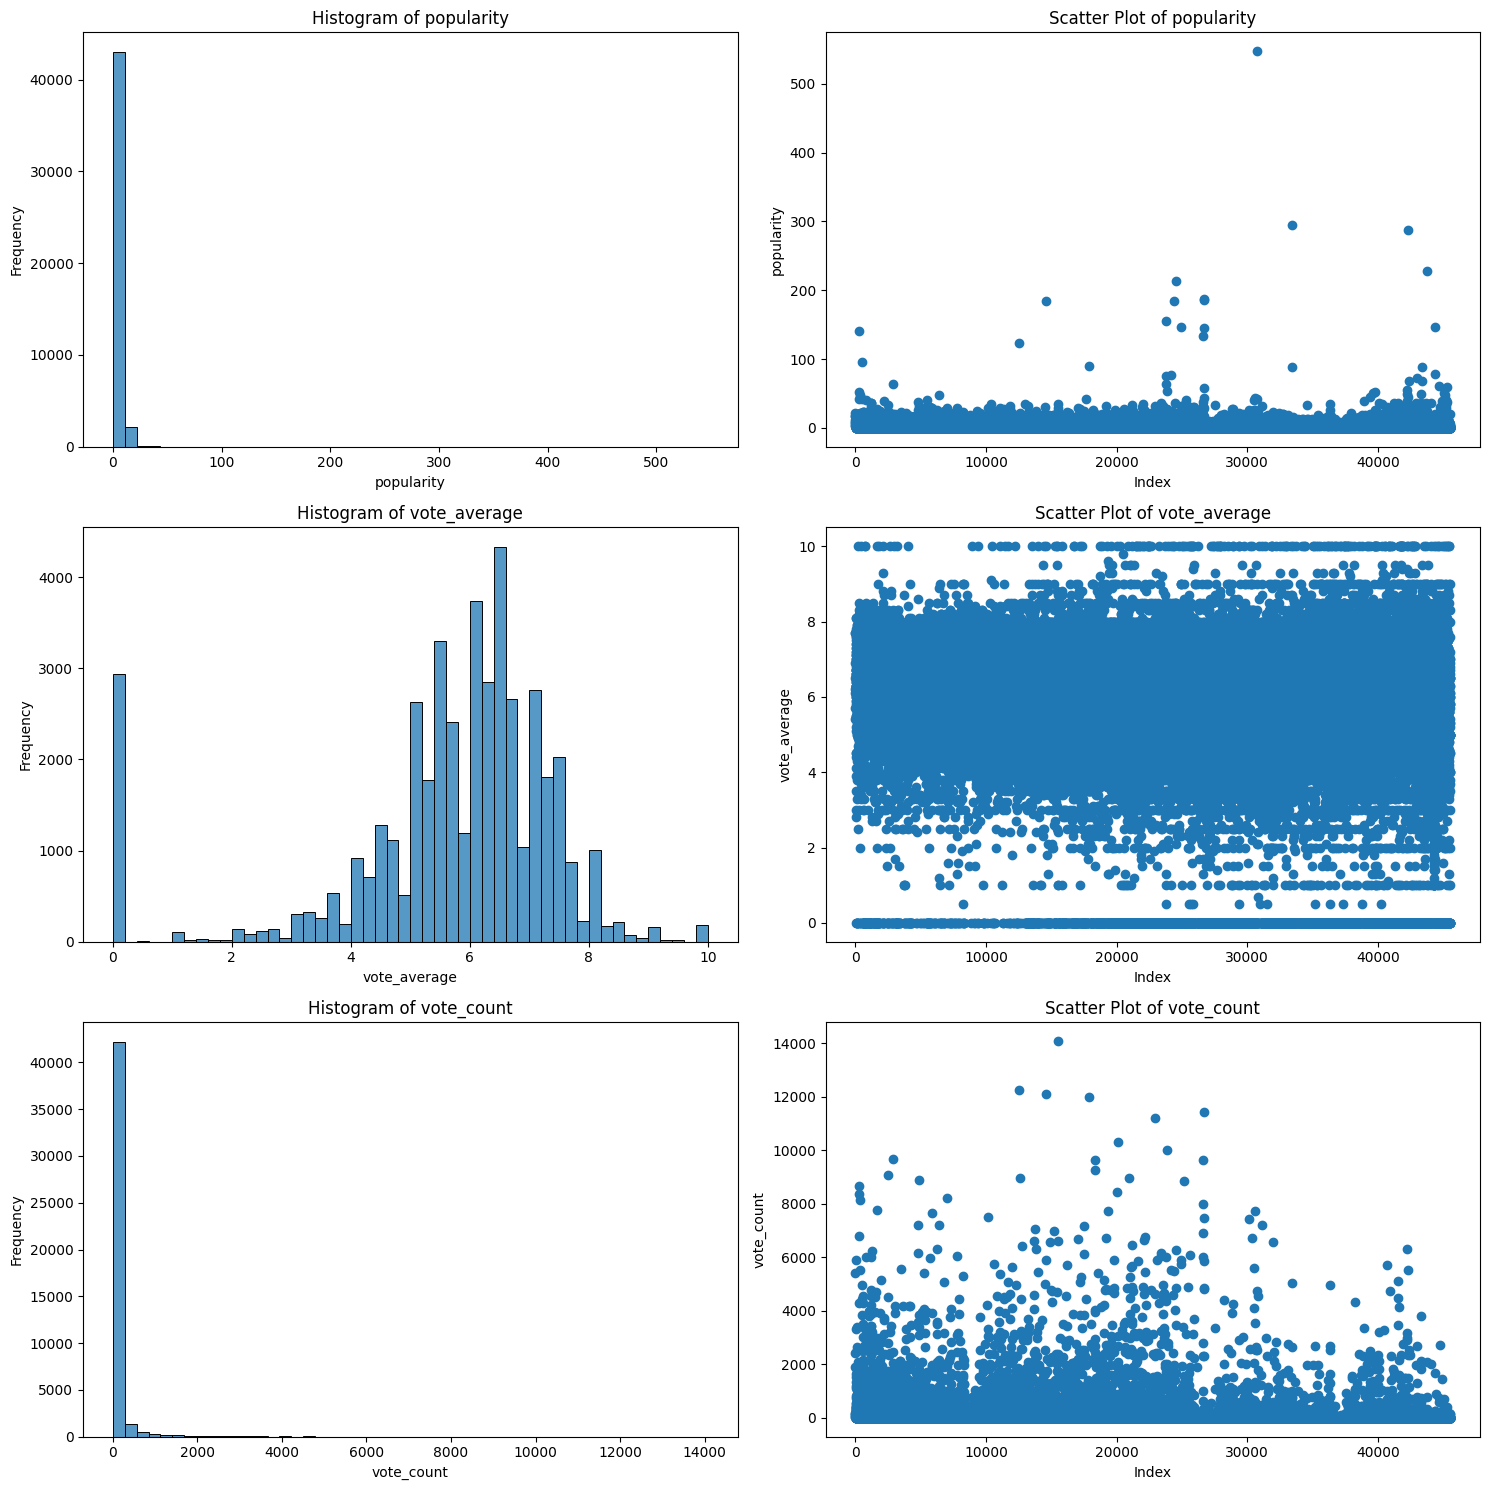

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
columnas = ['popularity','vote_average','vote_count']
for i in range(3):
    columna = columnas[i]
    ax = sns.histplot(data_num[columna], bins=50, kde=False, ax=axes[i, 0])
    ax.set_xlabel(columna)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {columna}')

    # Diagrama de dispersión
    axes[i, 1].scatter(data_num.index, data_num[columna])
    axes[i, 1].set_xlabel('Index')
    axes[i, 1].set_ylabel(columna)
    axes[i, 1].set_title(f'Scatter Plot of {columna}')


plt.tight_layout()  # Ajustar el espaciado entre los subplots
plt.show()  

La variable numérica con mejor comportamiento fue la de `popularity`, ya que tiene valores más precisos. Sin embargo, para mi análisis, tomé en cuenta que el rango de popularidad es [0-100%], de esta forma, los datos con un valor mayor que 100, tomarán ese valor.

In [16]:
data_num['popularity'] = data_num['popularity'].where((data_num['popularity'] >= 0) & (data_num['popularity'] <= 100), 100)

C:\Users\Bienvenido\AppData\Local\Temp\ipykernel_7136\1804084413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num['popularity'] = data_num['popularity'].where((data_num['popularity'] >= 0) & (data_num['popularity'] <= 100), 100)


Visualizamos el resultado.

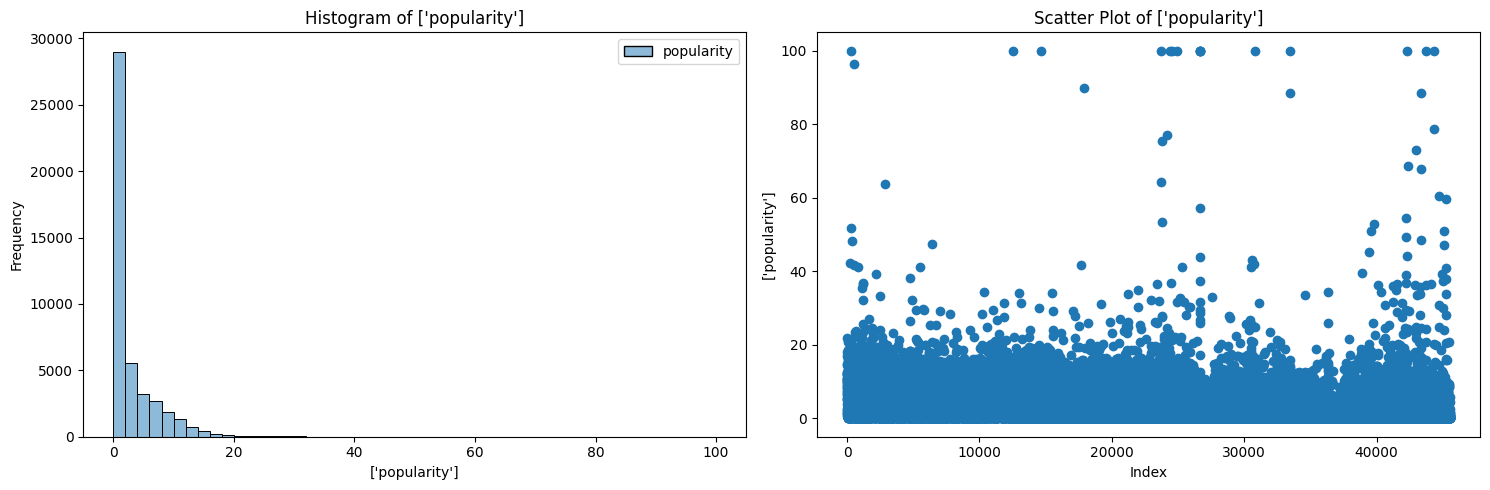

In [17]:
columna=['popularity']
fig, axes = plt.subplots(1, 2, figsize=(15,5))
ax = sns.histplot(data_num[columna], bins=50, kde=False, ax=axes[0])
ax.set_xlabel(columna)
ax.set_ylabel('Frequency')
ax.set_title(f'Histogram of {columna}')


    # Diagrama de dispersión
axes[1].scatter(data_num.index, data_num[columna])
axes[1].set_xlabel('Index')
axes[1].set_ylabel(columna)
axes[1].set_title(f'Scatter Plot of {columna}')
plt.tight_layout()  # Ajustar el espaciado entre los subplots
plt.show()

# Variables categóricas

Se seleccionaron las columnas más representativas para nuestro **_modelo de Recomendación de películas_**, las cuales fueron: `id`, `overview`, `production_companies`, `title`, `cast`, `director`

In [18]:
columnas = ['id', 'overview','genres', 'production_companies', 'title', 'cast', 'director']
data_peliculas = data[columnas]

Transformamos las columnas, reemplazando los espacios en en cada lista por cadenas vacías. Esto es un tipo de preprocesamiento, donde se  normalizaron los valores de las columnas, y posteriormente, facilitar su procesamiento.

In [19]:
data_peliculas['genres'] = data_peliculas['genres']. apply(lambda x:[i.replace(" ", "") for i in x])
data_peliculas['director'] = data_peliculas['director']. apply(lambda x:[i.replace(" ", "") for i in x])
data_peliculas['cast'] = data_peliculas['cast']. apply(lambda x:[i.replace(" ", "") for i in x])
data_peliculas['production_companies'] = data_peliculas['production_companies']. apply(lambda x:[i.replace(" ", "") for i in x])

C:\Users\Bienvenido\AppData\Local\Temp\ipykernel_7136\1419351606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_peliculas['genres'] = data_peliculas['genres']. apply(lambda x:[i.replace(" ", "") for i in x])
C:\Users\Bienvenido\AppData\Local\Temp\ipykernel_7136\1419351606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_peliculas['director'] = data_peliculas['director']. apply(lambda x:[i.replace(" ", "") for i in x])
C:\Users\Bienvenido\AppData\Local\Temp\ipykernel_7136\1419351606.py:3: S

In [20]:
data_peliculas.head(3)

,id,overview,genres,production_companies,title,cast,director
0,862,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]",[PixarAnimationStudios],Toy Story,"[TomHanks, TimAllen, DonRickles, JimVarney, Wa...",[JohnLasseter]
1,8844,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]","[TriStarPictures, TeitlerFilm, InterscopeCommu...",Jumanji,"[RobinWilliams, JonathanHyde, KirstenDunst, Br...",[JoeJohnston]
2,15602,A family wedding reignites the ancient feud be...,"[Romance, Comedy]","[WarnerBros., LancasterGate]",Grumpier Old Men,"[WalterMatthau, JackLemmon, Ann-Margret, Sophi...",[HowardDeutch]


Se rellenaron los valores nulos de la columna `overview`. Además, se transformaron los datos de la misma, donde se convirtieron los elementos de la columna en una lista de palabras individuales, espaciados. Lo que es ideal para el posterior análisis de palabras claves para las descripciones de las películas.

In [21]:
data_peliculas['overview'].fillna('Sin descripción', inplace=True)
data_peliculas['overview'] = data_peliculas['overview'].astype(str).apply(lambda x: x.split() if isinstance(x, str) else [])

C:\Users\Bienvenido\AppData\Local\Temp\ipykernel_7136\1850735135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_peliculas['overview'].fillna('Sin descripción', inplace=True)
C:\Users\Bienvenido\AppData\Local\Temp\ipykernel_7136\1850735135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_peliculas['overview'] = data_peliculas['overview'].astype(str).apply(lambda x: x.split() if isinstance(x, str) else [])


Luego, se realizo la concatenación de nuestras variables preprocesadas anteriormente. Y se obtuvo la base de datos que utilizaremos para nuestro _`Modelo de recomendación`_

In [22]:
data_peliculas['tags'] = data_peliculas['overview'] + data_peliculas['genres'] + data_peliculas['director'] 
new = data_peliculas.drop(columns=['overview','genres','cast','director', 'production_companies'])
#new.head()
new['tags'] = new['tags'].apply(lambda x: " ".join(x))
new['tags'] = new['tags'].apply(lambda x:x.lower())
new.head(3)

C:\Users\Bienvenido\AppData\Local\Temp\ipykernel_7136\1620219431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_peliculas['tags'] = data_peliculas['overview'] + data_peliculas['genres'] + data_peliculas['director']


,id,title,tags
0,862,Toy Story,"led by woody, andy's toys live happily in his ..."
1,8844,Jumanji,when siblings judy and peter discover an encha...
2,15602,Grumpier Old Men,a family wedding reignites the ancient feud be...


In [23]:
data = data.fillna(' ')

# **Modelo de Recomendación**

Se creó la columna tokenizada.

In [24]:
import nltk
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [25]:
def stem (text):
    y = []

    for i in text.split():
        y.append(ps.stem(i))
    
    return " ".join(y)


In [26]:
new['tags'] = new['tags'].apply(stem)

In [27]:
new

,id,title,tags
0,862,Toy Story,"led by woody, andy' toy live happili in hi roo..."
1,8844,Jumanji,when sibl judi and peter discov an enchant boa...
2,15602,Grumpier Old Men,a famili wed reignit the ancient feud between ...
3,31357,Waiting to Exhale,"cheat on, mistreat and step on, the women are ..."
4,11862,Father of the Bride Part II,just when georg bank ha recov from hi daughter...
...,...,...,...
45532,30840,Robin Hood,"yet anoth version of the classic epic, with en..."
45534,111109,Century of Birthing,an artist struggl to finish hi work while a st...
45535,67758,Betrayal,"when one of her hit goe wrong, a profession as..."
45536,227506,Satan Triumphant,"in a small town live two brothers, one a minis..."


Se creó la `matriz de similitud de coseno`

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
muestra = new.head(5000)

In [29]:
vectors = cv.fit_transform(muestra['tags'])

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vectors)

In [31]:
#from joblib import dump
#import gzip
#with gzip.open('modelo_similitud.joblib.gz', 'wb') as f:
  #  dump(similarity, f)

Se desarrolló y se puso a prueba la función para la Recomendación de peliculas del modelo

In [32]:
def recommend(movie):
    index = new[new['title'] == movie].index[0]
    distances = similarity[index] 
    similar = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])
    similar_indice = [i for i, _ in similar[1:6]]
    similar_pelis = muestra['title'].iloc[similar_indice].values.tolist()
    return similar_pelis

In [33]:
name = recommend('Cinderella')
print (name)

['The Truman Show', 'Sweet Nothing', 'Carried Away', 'Stardust Memories', 'The Hanging Garden']


Se guardaron las bases de datos para su utilización en el deployment.

In [35]:
import joblib 
joblib.dump(similarity, '_src/data/similarity.pkl', compress=True)
muestra.to_csv('_src/data/data_model.csv')
